<a href="https://colab.research.google.com/github/iabrilcabezas/dustbias/blob/main/tutorials/sky_components_SED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from scipy.constants import physical_constants
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size']=20
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1

In [29]:
!pip install camb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.2 MB/s eta 0:00:00


In [30]:
import camb

The aim of this notebook is to explain a plot such as [this one](https://www.aanda.org/articles/aa/full_html/2016/10/aa25967-15/F4.html), with a particular focus of Galactic dust.


The spectral radiance as a function of frequency from a black body at a given temperature is given by:
\begin{equation}
B_\nu(T) = \frac{2h\nu^3}{c^2}\frac{1}{e^x-1},\quad x = \frac{h\nu}{kT}
\end{equation}

In the Rayleigh-Jeans limit ($x\to0$), it becomes
\begin{equation}
B_\nu(T) = \frac{2kTh\nu^2}{c^2}
\end{equation}

As a result, we define the Rayleigh-Jeans temperature as
\begin{equation}
T_A = \frac{1}{2k}\left(\frac{c}{\nu}\right)^2 B_\nu(T)
\end{equation}

This is also known as "antenna-temperature".


In thermodynamic temperature units, the CMB spectral energy distribution is always one, i.e. $B_{\nu}(T)=1$. In order to convert from antenna temperature units to thermodynamic temperature, we use a similar procedure as when we want to express $B_{\nu}(T)$ in wavelength units, for which we impose
\begin{equation}
B_\nu(T)\mathrm{d}\nu = B_\lambda(T)\mathrm{d}\lambda
\end{equation}
Similarly,
\begin{equation}
\delta T_A = \frac{1}{2k}\left(\frac{c}{\nu}\right)^2 \frac{\mathrm{d}B_\nu(T)}{\mathrm{d}T}\delta T\\
\delta T_A = \frac{e^x x^2}{(e^x-1)^2}\delta T
\end{equation}

The conversion factor from antenna units to thermodynamic temperature is

\begin{equation}
g(\nu) = \frac{(e^x -1)^2}{e^x x^2}
\end{equation}

In [2]:
h_JHz = physical_constants['Planck constant'][0]
k_JK  = physical_constants['Boltzmann constant'][0]
T_CMB =  2.72548 # Fixsen+

In [3]:
def fcmb(nu):

    '''
    conversion factor from thermodynamic temperature to antenna units

    ** parameters **
    nu: float
        frequency in GHz
    '''

    x = h_JHz * 1e9/(k_JK*T_CMB) *nu
    return np.exp(x)*(x/(np.expm1(x)))**2

def gcmb(nu):

    '''
    conversion factor from antenna units to thermodynamic temperature

    ** parameters **
    nu: float
        frequency in GHz
    '''

    return 1/fcmb(nu)

Empirically, thermal dust emission is described as a modified blackbody spectra (in antenna temperature units):

\begin{equation}
   S_{\nu}^{d} = \left( \frac{\nu}{\nu_0^d}\right)^{\beta_d} \frac{B_\nu(\Theta_d)}{B_{\nu_0^d}(\Theta_d)}
\end{equation}

This expression can be simplified to
\begin{equation}
S_\nu^d = \left( \frac{\nu}{\nu_0^d}\right)^{\beta_d+1} \frac{e^{x_0}-1}{e^x-1}
\end{equation}

Typical values for the spectral index $\beta_d$ and the dust temperature $\Theta_d$ are $\beta_d = 1.59$, $\Theta_d = 19.6$. The pivot frequency $\nu_0^d$ typically chosen to calibrate this expression is $353\mathrm{GHz}$.

The extrapolation between different frequencies is always done in antenna temperature units, calibrated at the pivot frequency $\nu_0$.  If we are working on thermodynamic units, we need to 1- apply the factor $1/g(\nu_0)$, 2- do the extrapolation to the desired frequency and 3- bring back to thermodynamic units using $g(\nu)$.

In [81]:
#All spectra
def comp_sed_muKcmb(nu, typ, nu0=353, beta=1.59, temp=19.6):

    '''
    SED for CMB and dust components in thermodynamic temperature units
    '''

    if typ == 'cmb':
        return  np.ones_like(nu)
    if typ == 'dust':
        x_to=h_JHz/k_JK*1e9*nu/temp
        x_from=h_JHz/k_JK*1e9*nu0/temp
        return (nu/nu0)**(1+beta)*np.expm1(x_from)/np.expm1(x_to) * fcmb(nu0) / fcmb(nu)
    return None

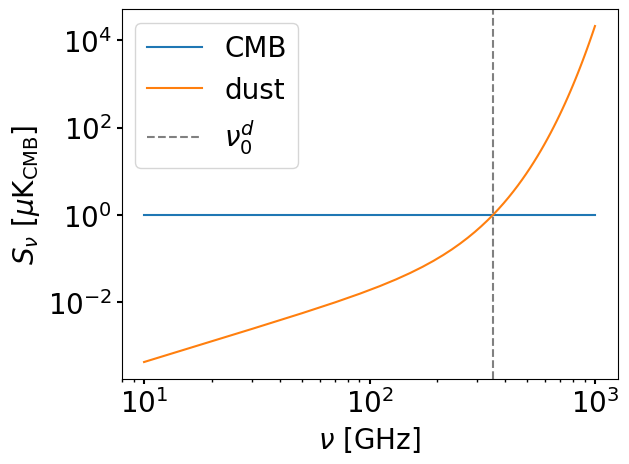

In [26]:
nu = np.linspace(10,1000)

fig, ax = plt.subplots(dpi=100)
ax.loglog(nu, comp_sed_muKcmb(nu, 'cmb'), label='CMB')
ax.loglog(nu, comp_sed_muKcmb(nu,'dust'), label='dust')

ax.set_xlabel(r'$\nu~[\mathrm{GHz}]$')
ax.set_ylabel(r'$S_\nu~[\mu\mathrm{K}_{\mathrm{CMB}}]$')

ax.axvline(353, color='gray', linestyle='dashed', label=r'$\nu_0^d$')
ax.legend()
plt.show()

This is not the end of the story. While we now know how to interpolate between frequencies, we still need information on the absolute amplitude of the CMB and dust. In particular, if we are interested on the brightness temperature of the CMB on $1^\circ$ scales, we will compute the CMB rms at multipole $\ell=180$ (see below). For this, we use CAMB to predict the amplitude of the CMB power spectra, since this is a measure of the variance of the CMB field at a given scale.

In [42]:
print(np.pi / np.deg2rad(1)) # 1 degree to multipole ell

180.0


In [43]:
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,
                       As=2e-9, ns=0.965, halofit_version='mead', lmax=3000)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, raw_cl=False, CMB_unit='muK')

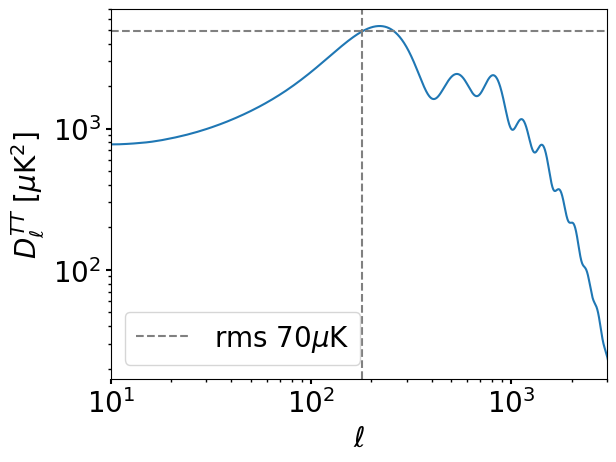

In [54]:
plt.loglog(powers['total'][:,0])# temperature
plt.axvline(180, color='gray', linestyle='dashed')
plt.axhline(powers['total'][:,0][180], color='gray', linestyle='dashed', label=f'rms {np.sqrt(powers["total"][:,0][180]):.0f}' + r'$\mu\mathrm{K}$')
plt.ylabel(r'$D_\ell^{TT}~[\mu\mathrm{K}^2]$')
plt.xlabel(r'$\ell$')
plt.xlim(10,3000)
plt.legend()
plt.show()

This explains why [the figure](https://www.aanda.org/articles/aa/full_html/2016/10/aa25967-15/F4.html) sets $A_\mathrm{CMB}=70\mu\mathrm{K}$. At $\ell=80$, $A_{\mathrm{CMB}} = 45\mu\mathrm{K}$.

Finally, for dust it is a bit more complicated because the amplitude of dust will vary depending on the footprint we use. In the paper (where they calibrate dust at $\nu_0^d = 545\mathrm{GHz}$) they set $A_d = 100 \mu\mathrm{K}$, but for a footprint with ~30% of the sky this can go down to $A_d = 14 \mu\mathrm{K}$ with $\nu_0^d=353\mathrm{GHz}, \ell_0=80$. In general, the dust amplitude will be parametrised as a power-law:

\begin{equation}
    \frac{\ell(\ell + 1)}{2\pi}C_\ell^{dd} = A_d \left(\frac{\ell}{\ell_0}\right)^{\alpha_d}
\end{equation}

OK, let's code up the figure:

In [69]:
#All spectra
def comp_sed_muRJ(nu, typ,A=1 ,nu0=353, beta=1.59, temp=19.6):

    '''
    SED for CMB and dust components in antenna temperature units
    '''

    if typ == 'cmb':
        return   A * fcmb(nu)
    if typ == 'dust':
        x_to=h_JHz/k_JK*1e9*nu/temp
        x_from=h_JHz/k_JK*1e9*nu0/temp
        return A * (nu/nu0)**(1+beta)*np.expm1(x_from)/np.expm1(x_to)
    return None

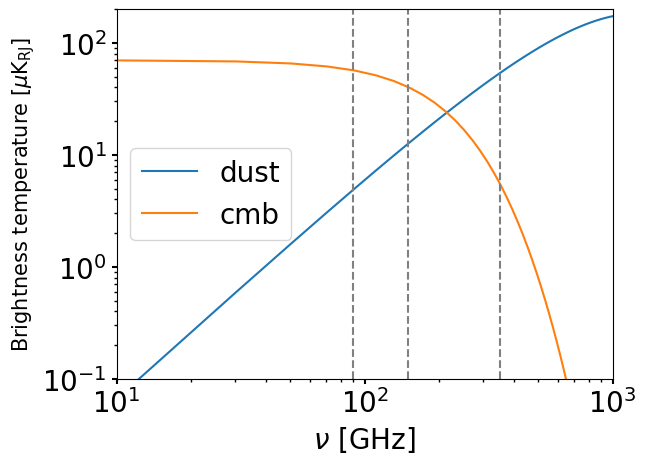

In [77]:
nu = np.linspace(10, 1000)

fig, ax = plt.subplots(dpi=100)
ax.loglog(nu, comp_sed_muRJ(nu, 'dust', 100, nu0=545, beta=2, temp=21), label='dust')
ax.loglog(nu, comp_sed_muRJ(nu, 'cmb', 70), label='cmb')
ax.axvline(90, color='gray', linestyle='dashed')
ax.set_ylim(1e-1, 2e2)
ax.set_xlim(10,1000)
ax.axvline(150, color='gray', linestyle='dashed')
ax.axvline(353, color='gray', linestyle='dashed')
ax.legend()

ax.set_xlabel(r'$\nu~[\mathrm{GHz}]$')
ax.set_ylabel(r'$\mathrm{Brightness~temperature}~[\mu\mathrm{K}_{\mathrm{RJ}}]$', fontsize=15)
plt.show()

which is the figure we wanted to reproduce:)

In [92]:
nu=np.array([90,150,353])
print(comp_sed_muKcmb(nu, 'dust')/comp_sed_muKcmb(90, 'dust'))

[ 1.          2.9475484  65.01919514]


Here we see that dust at 353 GHz is 65 times brighter than dust at 90 GHz. Dust at 150 GHz is 3 times brighter than dust at 90 GHz.